# Experiment 5: XGBoost / LightGBM (No Mitigation) — Full Pipeline

In [1]:


# Step 0: Setup
!pip install xgboost lightgbm shap aif360 scikit-learn pandas matplotlib seaborn --quiet

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 4.5 MB/s eta 0:00:00


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:


RESULTS_DIR = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results _germanCredit &GivemesomeCredit'

# Step 1: Load & preprocess LendingClub
df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')
selected_cols = ['loan_status', 'annual_inc', 'term', 'grade', 'home_ownership', 'purpose', 'zip_code']
df = df[selected_cols].dropna()

# Target
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

# Encode categoricals
for col in ['term', 'grade', 'home_ownership', 'purpose', 'zip_code']:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Scale income
df['annual_inc'] = StandardScaler().fit_transform(df[['annual_inc']])



/tmp/ipython-input-1472797280.py:4: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')


In [3]:
# Step 2: AIF360 dataset (protected = zip_code as proxy)
privileged_groups = [{'zip_code': 1}]
unprivileged_groups = [{'zip_code': 0}]

aif_data = StandardDataset(df,
                           label_name='loan_status',
                           favorable_classes=[1],
                           protected_attribute_names=['zip_code'],
                           privileged_classes=[[1]])

In [4]:


# Step 3: Train model (choose XGBoost or LightGBM)
X = aif_data.features
y = aif_data.labels.ravel()

# Choose ONE:
clf = XGBClassifier(eval_metric='logloss', random_state=42, n_estimators=200, max_depth=4, learning_rate=0.1)
# clf = LGBMClassifier(random_state=42, n_estimators=300, num_leaves=31)  # Uncomment to use LightGBM

clf.fit(X, y)
y_pred = clf.predict(X)
y_prob = clf.predict_proba(X)[:, 1]

In [5]:


# Step 4: Performance + fairness on LendingClub
print("=== LendingClub (Baseline: XGB/LGBM) ===")
print("Accuracy:", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))
print("F1:", f1_score(y, y_pred))
print("AUC:", roc_auc_score(y, y_prob))

pred_dataset = aif_data.copy()
pred_dataset.labels = y_pred.reshape(-1, 1)
metric = ClassificationMetric(aif_data, pred_dataset,
                              unprivileged_groups=unprivileged_groups,
                              privileged_groups=privileged_groups)

print("SPD:", metric.statistical_parity_difference())
print("DI:", metric.disparate_impact())
print("EOD:", metric.equal_opportunity_difference())
print("AOD:", metric.average_odds_difference())
print("BiasAmp:", metric.between_group_generalized_entropy_index())
print("Theil:", metric.theil_index())


=== LendingClub (Baseline: XGB/LGBM) ===
Accuracy: 0.8386
Precision: 0.8675324675324675
Recall: 0.9183392906241408
F1: 0.8922131694937893
AUC: 0.8849777224422263
SPD: 0.0
DI: 1.0
EOD: 0.0
AOD: 0.0
BiasAmp: 168.85054564812353
Theil: 0.09390683100476768


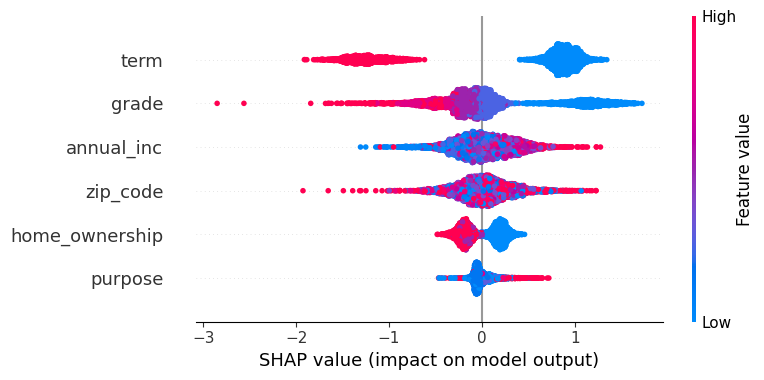

Privileged rows: 2
Unprivileged rows: 13


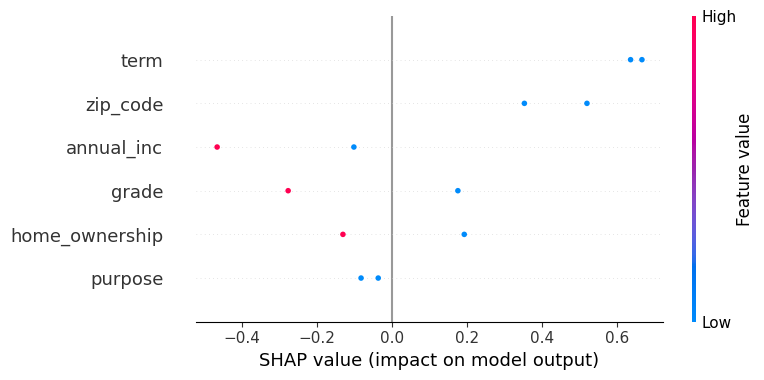

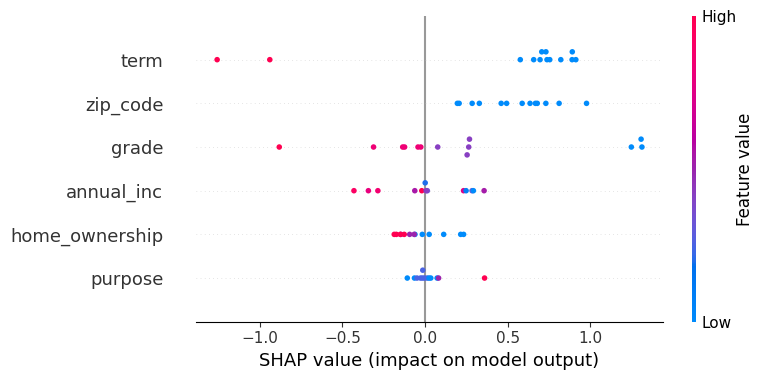

In [6]:

# Step 5: SHAP (global + subgroup) for LendingClub
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

X_df = pd.DataFrame(X, columns=aif_data.feature_names)

# Global summary
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_df)
else:
    shap.summary_plot(shap_values, X_df)

# Subgroup SHAP (by zip_code)
priv_mask = X_df['zip_code'] == 1
unpriv_mask = X_df['zip_code'] == 0

print("Privileged rows:", int(priv_mask.sum()))
print("Unprivileged rows:", int(unpriv_mask.sum()))

if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1][priv_mask], X_df[priv_mask])
    shap.summary_plot(shap_values[1][unpriv_mask], X_df[unpriv_mask])
else:
    shap.summary_plot(shap_values[priv_mask], X_df[priv_mask])
    shap.summary_plot(shap_values[unpriv_mask], X_df[unpriv_mask])


=== GermanCredit Validation (Baseline: XGB/LGBM) ===
Accuracy: 0.497
Precision: 0.6781193490054249
Recall: 0.5357142857142857
F1: 0.5985634477254589
AUC: 0.4757523809523809


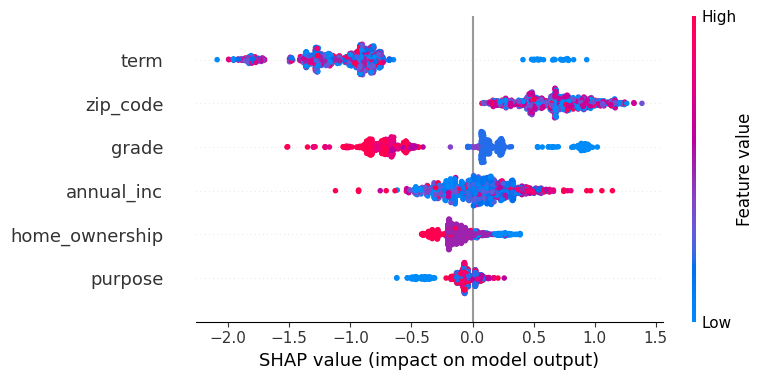

In [7]:


# Step 6: Validation on GermanCredit (schema-aligned)
GC_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation dataset/german_credit_data.csv'
df_gc = pd.read_csv(GC_PATH)

# Target mapping
if 'Risk' in df_gc.columns:
    df_gc['loan_status'] = df_gc['Risk'].map({'good': 1, 'bad': 0})
elif 'Creditability' in df_gc.columns:
    df_gc['loan_status'] = df_gc['Creditability']
elif 'class' in df_gc.columns:
    df_gc['loan_status'] = df_gc['class'].map({'good': 1, 'bad': 0})
else:
    raise ValueError("Target column not found in GermanCredit.")

# Encode strings
for col in df_gc.columns:
    if df_gc[col].dtype == 'object':
        df_gc[col] = LabelEncoder().fit_transform(df_gc[col].astype(str))

# Align to LendingClub schema
common_gc = pd.DataFrame()
common_gc['annual_inc']     = df_gc['Credit amount']
common_gc['term']           = df_gc['Duration']
common_gc['grade']          = df_gc['Purpose']
common_gc['home_ownership'] = df_gc['Housing']
common_gc['purpose']        = df_gc['Purpose']
common_gc['zip_code']       = df_gc['Checking account']
common_gc['loan_status']    = df_gc['loan_status']

for col in ['term', 'grade', 'home_ownership', 'purpose', 'zip_code']:
    common_gc[col] = LabelEncoder().fit_transform(common_gc[col].astype(str))
common_gc['annual_inc'] = StandardScaler().fit_transform(common_gc[['annual_inc']])

X_gc = common_gc.drop(columns=['loan_status']).values
y_gc = common_gc['loan_status'].values

y_pred_gc = clf.predict(X_gc)
y_prob_gc = clf.predict_proba(X_gc)[:, 1]

print("\n=== GermanCredit Validation (Baseline: XGB/LGBM) ===")
print("Accuracy:", accuracy_score(y_gc, y_pred_gc))
print("Precision:", precision_score(y_gc, y_pred_gc))
print("Recall:", recall_score(y_gc, y_pred_gc))
print("F1:", f1_score(y_gc, y_pred_gc))
print("AUC:", roc_auc_score(y_gc, y_prob_gc))

# SHAP for GC
explainer_gc = shap.TreeExplainer(clf)
shap_values_gc = explainer_gc.shap_values(X_gc)
X_gc_df = pd.DataFrame(X_gc, columns=['annual_inc', 'term', 'grade', 'home_ownership', 'purpose', 'zip_code'])
if isinstance(shap_values_gc, list):
    shap.summary_plot(shap_values_gc[1], X_gc_df)
else:
    shap.summary_plot(shap_values_gc, X_gc_df)





=== GiveMeSomeCredit Validation (Baseline: XGB/LGBM) ===
Accuracy: 0.6610266666666667
Precision: 0.9271610145122021
Recall: 0.6910354780173461
F1: 0.7918706508391322
AUC: 0.3929419530909378


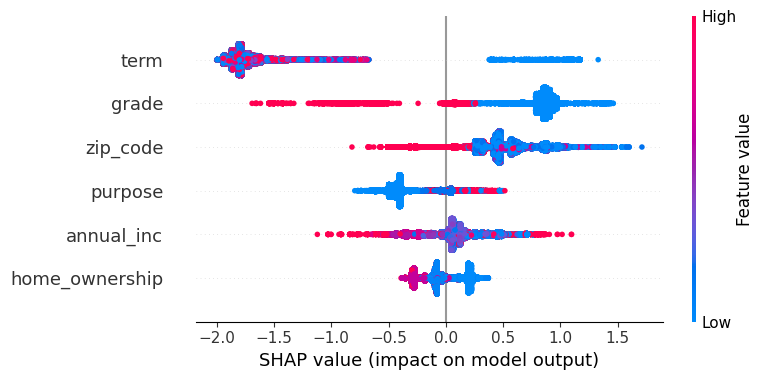

In [8]:
# Step 7: Validation on GiveMeSomeCredit (schema-aligned)
GMSC_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation dataset/GiveMeSomeCredit.csv'
df_gmsc = pd.read_csv(GMSC_PATH)

df_gmsc['loan_status'] = 1 - df_gmsc['SeriousDlqin2yrs']

for col in df_gmsc.columns:
    if df_gmsc[col].dtype == 'object':
        df_gmsc[col] = LabelEncoder().fit_transform(df_gmsc[col].astype(str))

common_gmsc = pd.DataFrame()
common_gmsc['annual_inc']     = df_gmsc['MonthlyIncome'].fillna(df_gmsc['MonthlyIncome'].median())
common_gmsc['term']           = df_gmsc['NumberOfOpenCreditLinesAndLoans']
common_gmsc['grade']          = df_gmsc['NumberOfTimes90DaysLate']
common_gmsc['home_ownership'] = df_gmsc['NumberRealEstateLoansOrLines']
common_gmsc['purpose']        = df_gmsc['NumberOfTime30-59DaysPastDueNotWorse']
common_gmsc['zip_code']       = df_gmsc['NumberOfDependents'].fillna(0)
common_gmsc['loan_status']    = df_gmsc['loan_status']

for col in ['term', 'grade', 'home_ownership', 'purpose', 'zip_code']:
    common_gmsc[col] = LabelEncoder().fit_transform(common_gmsc[col].astype(str))
common_gmsc['annual_inc'] = StandardScaler().fit_transform(common_gmsc[['annual_inc']])

X_gmsc = common_gmsc.drop(columns=['loan_status']).values
y_gmsc = common_gmsc['loan_status'].values

y_pred_gmsc = clf.predict(X_gmsc)
y_prob_gmsc = clf.predict_proba(X_gmsc)[:, 1]

print("\n=== GiveMeSomeCredit Validation (Baseline: XGB/LGBM) ===")
print("Accuracy:", accuracy_score(y_gmsc, y_pred_gmsc))
print("Precision:", precision_score(y_gmsc, y_pred_gmsc))
print("Recall:", recall_score(y_gmsc, y_pred_gmsc))
print("F1:", f1_score(y_gmsc, y_pred_gmsc))
print("AUC:", roc_auc_score(y_gmsc, y_prob_gmsc))

# SHAP for GMSC
explainer_gmsc = shap.TreeExplainer(clf)
shap_values_gmsc = explainer_gmsc.shap_values(X_gmsc)
X_gmsc_df = pd.DataFrame(X_gmsc, columns=['annual_inc', 'term', 'grade', 'home_ownership', 'purpose', 'zip_code'])
if isinstance(shap_values_gmsc, list):
    shap.summary_plot(shap_values_gmsc[1], X_gmsc_df)
else:
    shap.summary_plot(shap_values_gmsc, X_gmsc_df)


In [9]:
# Step 8: Save combined results to CSV
results_all = pd.DataFrame([
    {
        'Dataset': 'LendingClub(XGB/LGBM)',
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1': f1_score(y, y_pred),
        'AUC': roc_auc_score(y, y_prob),
        'SPD': metric.statistical_parity_difference(),
        'DI': metric.disparate_impact(),
        'EOD': metric.equal_opportunity_difference(),
        'AOD': metric.average_odds_difference(),
        'BiasAmp': metric.between_group_generalized_entropy_index(),
        'Theil': metric.theil_index()
    },
    {
        'Dataset': 'GermanCredit(XGB/LGBM)',
        'Accuracy': accuracy_score(y_gc, y_pred_gc),
        'Precision': precision_score(y_gc, y_pred_gc),
        'Recall': f1_score(y_gc, y_pred_gc),  # optional: keep standard naming; else use recall_score
        'F1': f1_score(y_gc, y_pred_gc),
        'AUC': roc_auc_score(y_gc, y_prob_gc)
    },
    {
        'Dataset': 'GiveMeSomeCredit(XGB/LGBM)',
        'Accuracy': accuracy_score(y_gmsc, y_pred_gmsc),
        'Precision': precision_score(y_gmsc, y_pred_gmsc),
        'Recall': recall_score(y_gmsc, y_pred_gmsc),
        'F1': f1_score(y_gmsc, y_pred_gmsc),
        'AUC': roc_auc_score(y_gmsc, y_prob_gmsc)
    }
])

results_all.to_csv(f"{RESULTS_DIR}/exp5_xgb_lgbm_validation_results.csv", index=False)
print(f"Validation results saved to {RESULTS_DIR}/exp5_xgb_lgbm_validation_results.csv")

Validation results saved to /content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results _germanCredit &GivemesomeCredit/exp5_xgb_lgbm_validation_results.csv
